In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports (used later)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df  = pd.read_csv("/content/uber.csv")

In [4]:
display(df.head())

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [6]:
print("\nColumns:", list(df.columns))


Columns: ['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']


In [7]:
print("\nMissing values per column:\n", df.isnull().sum())


Missing values per column:
 Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


In [8]:
# Drop obvious irrelevant columns if they exist (errors='ignore' to avoid exceptions)
df = df.drop(columns=['Unnamed: 0', 'key'], errors='ignore')

In [9]:
# Some basic sanity filters: remove rows with missing pickup_datetime or fare_amount
df = df[~df['pickup_datetime'].isnull()] if 'pickup_datetime' in df.columns else df
df = df[~df['fare_amount'].isnull()] if 'fare_amount' in df.columns else df

In [10]:
print("After dropping irrelevant/missing rows shape:", df.shape)

After dropping irrelevant/missing rows shape: (200000, 7)


In [11]:
display(df.head())

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [12]:
if 'pickup_datetime' in df.columns:
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
    # Remove any rows where parse failed
    df = df[~df['pickup_datetime'].isnull()]
    df = df.reset_index(drop=True)
    # create time features
    df['hour'] = df['pickup_datetime'].dt.hour
    df['day'] = df['pickup_datetime'].dt.day
    df['month'] = df['pickup_datetime'].dt.month
    df['year'] = df['pickup_datetime'].dt.year
    df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
else:
    print("Warning: pickup_datetime not found — time-based features will be unavailable.")

display(df[['pickup_datetime','hour','day','month','year','dayofweek']].head())

,pickup_datetime,hour,day,month,year,dayofweek
0,2015-05-07 19:52:06+00:00,19,7,5,2015,3
1,2009-07-17 20:04:56+00:00,20,17,7,2009,4
2,2009-08-24 21:45:00+00:00,21,24,8,2009,0
3,2009-06-26 08:22:21+00:00,8,26,6,2009,4
4,2014-08-28 17:47:00+00:00,17,28,8,2014,3


In [13]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric cols:", numeric_cols)


Numeric cols: ['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hour', 'day', 'month', 'year', 'dayofweek']


In [14]:
for c in numeric_cols:
    missing = df[c].isnull().sum()
    if missing > 0:
        med = df[c].median()
        df[c].fillna(med, inplace=True)
        print(f"Filled {missing} missing in {c} with median={med}")

Filled 1 missing in dropoff_longitude with median=-73.98009300000001
Filled 1 missing in dropoff_latitude with median=40.753042


/tmp/ipython-input-2094586617.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(med, inplace=True)


In [15]:
if 'passenger_count' in df.columns:
    df['passenger_count'] = df['passenger_count'].fillna(1).astype(int)
    df['passenger_count'] = df['passenger_count'].clip(lower=1, upper=6)


In [16]:
if 'fare_amount' in df.columns:
    df = df[df['fare_amount'] > 0]


In [17]:
df = df.reset_index(drop=True)
print("After imputation shape:", df.shape)

After imputation shape: (199978, 12)


In [18]:
def iqr_clip(series, lower_q=0.25, upper_q=0.75):
    Q1 = series.quantile(lower_q)
    Q3 = series.quantile(upper_q)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower, upper)

Columns to IQR-clip: ['fare_amount', 'passenger_count', 'hour', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']


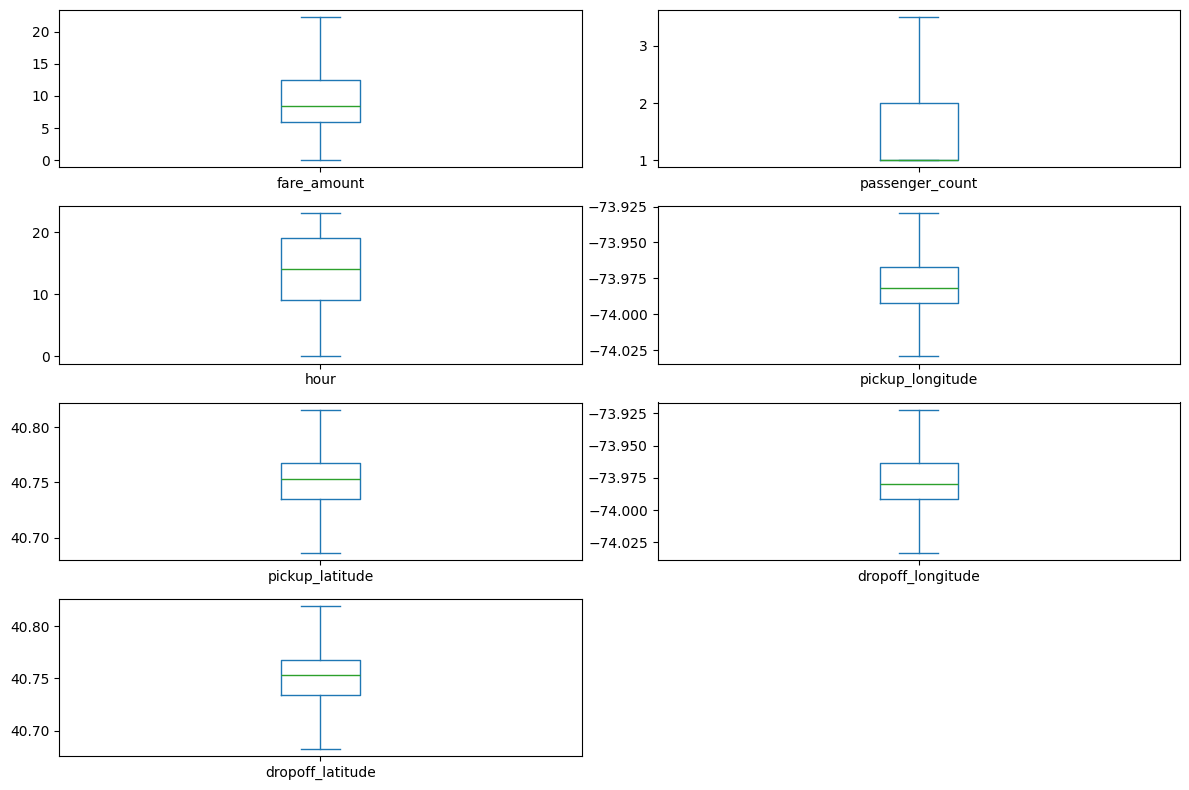

In [19]:
cols_to_treat = []
for c in ['fare_amount','passenger_count','hour','dist_travel_km','pickup_longitude','pickup_latitude',
          'dropoff_longitude','dropoff_latitude']:
    if c in df.columns:
        cols_to_treat.append(c)

print("Columns to IQR-clip:", cols_to_treat)
for c in cols_to_treat:
    df[c] = iqr_clip(df[c])

# Optional: show boxplots after clipping for quick visual check (may be many plots)
df[cols_to_treat].plot(kind='box', subplots=True, layout=(int(np.ceil(len(cols_to_treat)/2)),2), figsize=(12,8))
plt.tight_layout()
plt.show()

In [20]:
import sys
try:
    import haversine as hs
except Exception:
    !pip install -q haversine
    import haversine as hs

In [21]:
def haversine_km(row):
    try:
        loc1 = (float(row['pickup_latitude']), float(row['pickup_longitude']))
        loc2 = (float(row['dropoff_latitude']), float(row['dropoff_longitude']))
        return hs.haversine(loc1, loc2)  # returns kilometers by default
    except Exception:
        return np.nan

In [22]:
required_geo = {'pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'}
if required_geo.issubset(df.columns):
    df['dist_travel_km'] = df.apply(haversine_km, axis=1)
    # drop rows where distance is NaN (bad coords)
    df = df[~df['dist_travel_km'].isnull()].reset_index(drop=True)
else:
    raise KeyError("Geo coordinate columns missing; cannot compute dist_travel_km.")


In [23]:
df = df[(df['dist_travel_km'] >= 0.1) & (df['dist_travel_km'] <= 200)].reset_index(drop=True)
print("After distance filtering, shape:", df.shape)
display(df[['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','dist_travel_km']].head())

After distance filtering, shape: (197516, 13)


,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,dist_travel_km
0,40.738354,-73.999817,40.723217,-73.999512,1.683325
1,40.728225,-73.994355,40.750325,-73.994710,2.457593
2,40.740770,-74.005043,40.772647,-73.962565,5.036384
3,40.790844,-73.976124,40.803349,-73.965316,1.661686
4,40.744085,-73.929790,40.761247,-73.973082,4.115808


In [24]:
df = df[
    (df['pickup_latitude'].between(-90,90)) &
    (df['dropoff_latitude'].between(-90,90)) &
    (df['pickup_longitude'].between(-180,180)) &
    (df['dropoff_longitude'].between(-180,180))
].reset_index(drop=True)
print("After coordinate sanity check:", df.shape)


After coordinate sanity check: (197516, 13)


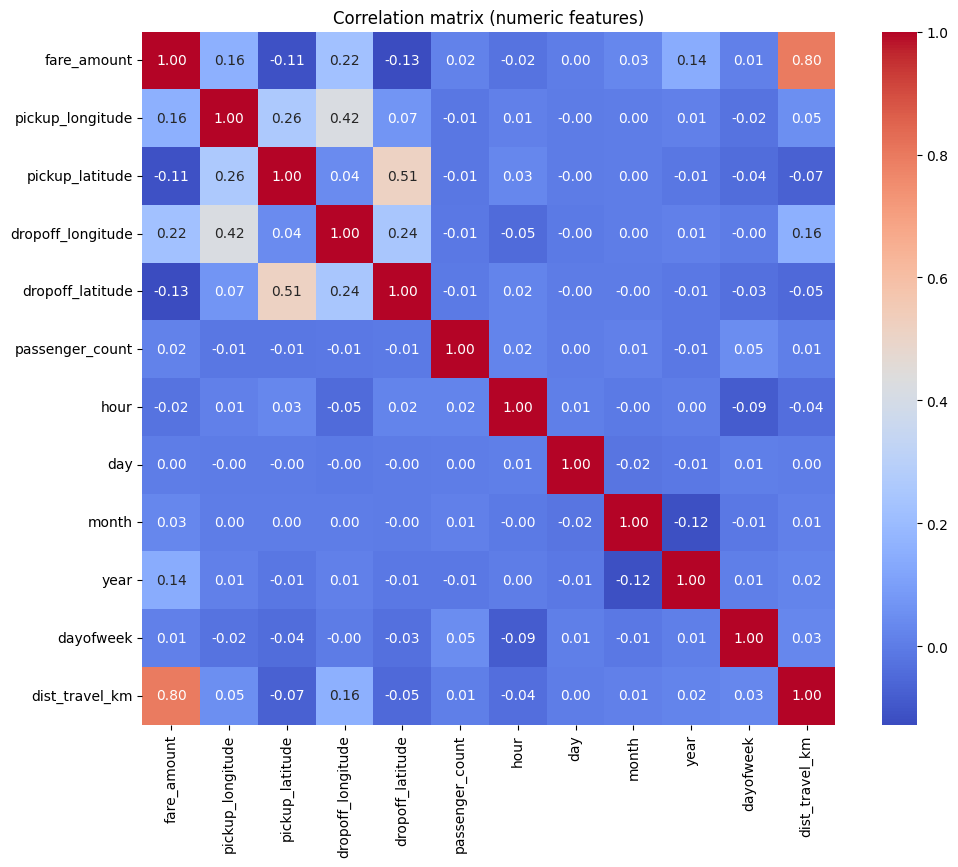

In [25]:
num = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12,9))
sns.heatmap(num.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation matrix (numeric features)")
plt.show()

In [26]:
if 'fare_amount' in num.columns:
    corrs = num.corr()['fare_amount'].abs().sort_values(ascending=False)
    print("Top correlations with fare_amount:\n", corrs.head(10))


Top correlations with fare_amount:
 fare_amount          1.000000
dist_travel_km       0.795023
dropoff_longitude    0.221506
pickup_longitude     0.156705
year                 0.142290
dropoff_latitude     0.127011
pickup_latitude      0.111816
month                0.031030
hour                 0.023566
passenger_count      0.015705
Name: fare_amount, dtype: float64


In [28]:
feature_cols = []
candidates = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude',
              'passenger_count','hour','day','month','year','dayofweek','dist_travel_km']
for c in candidates:
    if c in df.columns:
        feature_cols.append(c)

if 'fare_amount' not in df.columns:
    raise KeyError("Expected target column 'fare_amount' not found in dataset.")

X = df[feature_cols].copy()
y = df['fare_amount'].copy()

print("Using features:", feature_cols)
print("X shape:", X.shape, "y shape:", y.shape)
display(X.head())

Using features: ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hour', 'day', 'month', 'year', 'dayofweek', 'dist_travel_km']
X shape: (197516, 11) y shape: (197516,)


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,dist_travel_km
0,-73.999817,40.738354,-73.999512,40.723217,1.0,19,7,5,2015,3,1.683325
1,-73.994355,40.728225,-73.994710,40.750325,1.0,20,17,7,2009,4,2.457593
2,-74.005043,40.740770,-73.962565,40.772647,1.0,21,24,8,2009,0,5.036384
3,-73.976124,40.790844,-73.965316,40.803349,3.0,8,26,6,2009,4,1.661686
4,-73.929790,40.744085,-73.973082,40.761247,3.5,17,28,8,2014,3,4.115808


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Train/test shapes:", X_train.shape, X_test.shape)


Train/test shapes: (158012, 11) (39504, 11)


In [30]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
display(X_train_scaled.head())

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,dayofweek,dist_travel_km
127291,0.222386,1.330041,-0.482885,0.173133,1.699189,1.150893,0.611570,-0.664434,0.137274,1.003554,0.273585
75544,-0.861482,0.143904,-0.980976,0.481538,-0.593882,0.076839,0.151084,-0.373468,-1.478924,1.516963,-0.756058
14291,2.365605,-2.490260,2.363989,-2.354372,0.552653,1.150893,-0.885011,-0.955399,0.676007,0.490145,-0.923868
121200,-0.190347,0.966241,0.554999,1.862650,2.272457,0.537147,0.726692,-0.664434,1.753473,-0.536673,0.326796
89710,-1.330355,-1.217505,-1.487453,-1.037739,-0.593882,-0.690343,0.266205,1.372325,-1.478924,-0.536673,-1.082291


In [31]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge(alpha=1.0)': Ridge(alpha=1.0, random_state=42),
    'Lasso(alpha=0.1)': Lasso(alpha=0.1, random_state=42, max_iter=5000)
}


In [33]:
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results.append({'model': name, 'mse': mse, 'rmse': rmse, 'r2': r2})
    print(f"--- {name} ---")
    print(f"R2: {r2:.4f}, RMSE: {rmse:.4f}, MSE: {mse:.4f}")
    print("First 8 predictions vs actual:\n", np.vstack((y_pred[:8], y_test.values[:8])).T)
    print()

--- LinearRegression ---
R2: 0.6704, RMSE: 3.1036, MSE: 9.6322
First 8 predictions vs actual:
 [[ 6.9241458   7.7       ]
 [ 6.77083008  6.1       ]
 [ 9.50464256  8.5       ]
 [ 6.60759752  4.5       ]
 [ 6.04601886  6.5       ]
 [11.88607111 12.9       ]
 [ 6.78061436  6.9       ]
 [ 7.11248673  6.9       ]]

--- Ridge(alpha=1.0) ---
R2: 0.6704, RMSE: 3.1036, MSE: 9.6322
First 8 predictions vs actual:
 [[ 6.92416647  7.7       ]
 [ 6.77085306  6.1       ]
 [ 9.50464696  8.5       ]
 [ 6.60762168  4.5       ]
 [ 6.04604191  6.5       ]
 [11.88605354 12.9       ]
 [ 6.78063397  6.9       ]
 [ 7.11250181  6.9       ]]

--- Lasso(alpha=0.1) ---
R2: 0.6684, RMSE: 3.1130, MSE: 9.6905
First 8 predictions vs actual:
 [[ 7.35548901  7.7       ]
 [ 6.77619175  6.1       ]
 [ 9.40428098  8.5       ]
 [ 6.6144483   4.5       ]
 [ 6.29862044  6.5       ]
 [12.01254179 12.9       ]
 [ 7.01123745  6.9       ]
 [ 7.21648433  6.9       ]]



In [34]:
results_df = pd.DataFrame(results).sort_values('r2', ascending=False).reset_index(drop=True)
display(results_df)

,model,mse,rmse,r2
0,Ridge(alpha=1.0),9.632218,3.103582,0.670400
1,LinearRegression,9.632222,3.103582,0.670400
2,Lasso(alpha=0.1),9.690479,3.112953,0.668406


In [35]:
best_model_name = results_df.loc[0,'model']
print("Best model according to R2:", best_model_name)
best_model = models[best_model_name]  # these models have been trained already


Best model according to R2: Ridge(alpha=1.0)


In [36]:
y_pred_best = best_model.predict(X_test_scaled)
residuals = y_test - y_pred_best

Text(0.5, 1.0, 'Residuals vs Predicted (Ridge(alpha=1.0))')

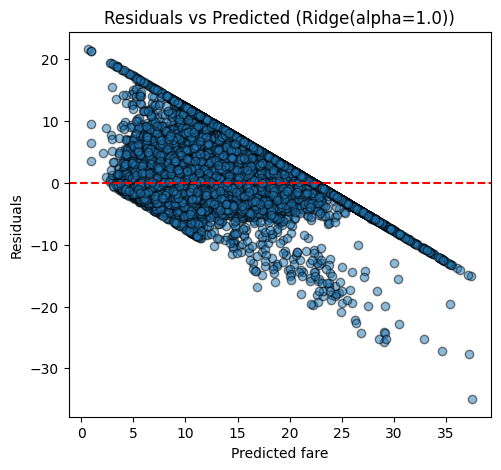

In [37]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_pred_best, residuals, alpha=0.5, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted fare")
plt.ylabel("Residuals")
plt.title(f"Residuals vs Predicted ({best_model_name})")


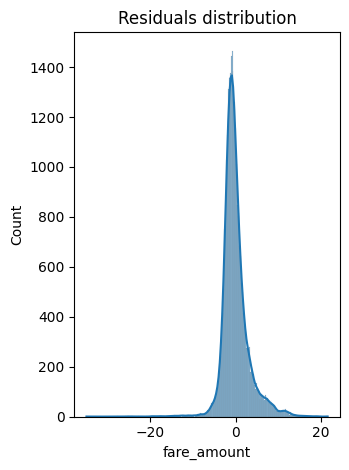

In [38]:
plt.subplot(1,2,2)
sns.histplot(residuals, kde=True)
plt.title("Residuals distribution")
plt.tight_layout()
plt.show()